# Standalone Analytic Samplers for Degree Constrained Trees

In this Jupyter notebook, we fully implement, using standard Python libraries, very generic analytic samplers which can generate non-plane unlabeled trees given any constraint on the degrees. — J. Lumbroso & R. Sedgewick, Princeton, 17-03-2018.

In [1]:
%matplotlib inline

## Polynomial utility functions

In [2]:
def poly_eval(x, coeff):
    result = coeff[-1]
    for i in range(-2, -len(coeff)-1, -1):
        result = result*x + coeff[i]
    return result

In [3]:
def poly_findroot(coeff, min_x=0.0, max_x=1.0, epsilon=0.01, target=0.0, failsafe=0.001):
    lo = min_x
    hi = max_x
    old = -1.0
    
    while True:
        mid = lo + (hi - lo)/2
        val = poly_eval(x=mid, coeff=coeff)
        
        err = val - target
        
        imp = abs(old-val)
        if imp < failsafe:
            return None
        old = val
        
        if abs(err) < epsilon:
            return mid
        
        if err > 0.0:
            # We are larger than target
            hi = mid - 1
        else:
            lo = mid + 1

In [4]:
def poly_df(coeff):
    df_coeff = coeff[:]
    df_coeff[-1] = 0
    for i in range(1, len(coeff)):
        df_coeff[i-1] = i * coeff[i]
    return df_coeff

## Tree utility functions

Following Example VII.13 page 473. 

In [5]:
def tree_find_singularity(degree_constraints, epsilon=0.01, failsafe=0.001):
    
    const_fac = degree_constraints[0]
    eta_poly = degree_constraints[:]
    eta_poly[0] = 0
    
    # solve first equation
    eq1 = poly_df(coeff=eta_poly)
    eq1[0] -= 1
    s = poly_findroot(coeff=eq1, epsilon=epsilon, failsafe=failsafe)
    
    if s == None:
        return None
    
    # solve second equation
    r = s - poly_eval(x=s, coeff=eta_poly)
    
    return (r/const_fac, s)

In [6]:
def tree_find_critical_branching(degree_constraints, epsilon=0.01, failsafe=0.001):
    
    if len(degree_constraints) > 0 and degree_constraints[0] == 0:
        raise Exception("There needs to be at least one terminal case (node of degree 0).")
        
    if len(degree_constraints) > 1 and degree_constraints[1] != 0:
        raise Exception("Unary nodes are not supported in external node representation " +
                        "of trees (because an arbitrary chain of them does not affect " +
                        "the size of the generated object.")
    
    (rho, Trho) = tree_find_singularity(degree_constraints=degree_constraints,
                                        epsilon=epsilon, failsafe=failsafe)
    
    branching = [0] * len(degree_constraints)
    
    if len(branching) > 0:
        branching[0] = degree_constraints[0] * rho / Trho
        
    if len(branching) > 2:
        for i in range(2, len(degree_constraints)):
            if degree_constraints[i] != 0:
                branching[i] = degree_constraints[i] * (Trho**(i-1))
    
    return branching

## Plotting utility functions

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
def tree_weighting_uniform(subtree_size, neighbors_total_size, neighbors_count, width):
    return width * 1 / neighbors_count

def tree_weighting_bysize1(subtree_size, neighbors_total_size, neighbors_count, width):
    return width * subtree_size / neighbors_total_size

TW_UNIFORM=tree_weighting_uniform
TW_WEIGHTED=tree_weighting_bysize1

In [9]:
def tree_hierarchy_pos(G, root=0,
                  x_left=0.0, x_right=1.0,
                  y_start=0, y_levelgap=0.2,
                  tree_weighting=TW_WEIGHTED,
                  pos=None, sizes=None, parent=None):
    """
    Creates a hierarchical plot of a tree-like graph for `networkx` and `matplotlib`'s
    plotting methods. (Adapted from Joel Miller, https://stackoverflow.com/a/29597209/408734)
    
    :param root: Identifier of the root of the current subtree.
    :type root: str / int
    
    :param x_left: Left of the subtree's bounding box (to avoid overlap).
    :type x_left: float
    
    :param x_right: Right of the subtree's bounding box (to avoid overlap).
    :type x_right: float
    
    :param y_start: Vertical position of the root.
    :type y_start: float
    
    :param y_levelgap: Increment by which to space the next level of the tree.
    :type y_levelgap: float
    
    :param size_weighting: Function allowing differenting weighting of the subtrees' size.
    :type size_weighting: function
    
    :param pos: (Recursive parameter.) Dictionary containing nodes assigned coordinates.
    :type pos: dict
    
    :param sizes: (Recursive parameter.) Dictionary of the sizes of the subtrees.
    :type sizes: str / int
    
    :param parent: (Recursive parameter.) Identifier of the parent node of this branch.
    :type parent: str / int
    """
    
    # Compute sizes, then precompute them (this step is necessary for weighting subtrees)
    if sizes == None:
        sizes = tree_sizes(G, root)
    
    # Compute local stats that are useful
    width = x_right - x_left
    x_center = x_left + width/2.0
    
    # Add the current root's position
    root_pos = (x_center, y_start)
    if pos == None:
        pos = {}
    elif root in pos:
        raise Exception("Cycle detected within the graph that would cause infinite recursion.")
    pos[root] = root_pos
    
    # Look for neighbors
    neighbors = list(G.neighbors(root))
    if parent != None and parent in neighbors:
        neighbors.remove(parent)
    
    # Compute position of neighbors and proceed recursively
    if len(neighbors) != 0:
        
        
        # Weighting by size (replace 'lambda s: s' by 'lambda s: 1' for uniform widths)
        neighbors_sizes = list(map(lambda n: sizes[n], neighbors))
        neighbors_total = sum(neighbors_sizes)
        
        def util_f(s):
            return tree_weighting(subtree_size=s,
                                  neighbors_total_size=neighbors_total,
                                  neighbors_count=len(neighbors),
                                  width=width)
        
        neighbors_width = list(map(util_f, neighbors_sizes))
        
        #nextx = xcenter - width/2 - dx/2
        
        next_x_left = x_left
        
        for i in range(len(neighbors)):
            neighbor = neighbors[i]
            neighbor_width = neighbors_width[i]
            neighbor_x_left = next_x_left
            neighbor_x_right = next_x_left + neighbor_width
            
            pos = tree_hierarchy_pos(
                G, root=neighbor,
                x_left=neighbor_x_left, x_right=neighbor_x_right,
                y_start=y_start-y_levelgap, y_levelgap=y_levelgap,
                tree_weighting=tree_weighting,
                pos=pos, sizes=sizes, parent=root)
            
            next_x_left = neighbor_x_right
    
    return pos

In [10]:
def tree_sizes(G, root, sizes=None, parent=None):
    """
    Computes recursively the size of every subtree of graph `G` starting from
    the node `root`.
    """
    if sizes == None:
        sizes = {}
    elif root in sizes:
        return sizes[root]
    
    # Look for neighbors
    neighbors = list(G.neighbors(root))
    if parent != None and parent in neighbors:
        neighbors.remove(parent)
    
    # Recursively compute sizes
    size = 1
    for neighbor in neighbors:
        sizes = tree_sizes(G, neighbor, sizes=sizes, parent=root)
        size += sizes[neighbor]
        
    # Store and return
    sizes[root] = size
    return sizes

In [11]:
def plot_tree(G, tree_weighting=TW_WEIGHTED, filename=None):
    node_positions = tree_hierarchy_pos(G, tree_weighting=tree_weighting)
    nx.draw(G, node_positions, with_labels=False, arrows=False, node_size=0.5)
    if filename != None:
        plt.savefig(filename, format='pdf', dpi=1000)

## Random generation of trees

In [12]:
import random

In [13]:
def random_discrete(p):
    if sum(p) != 1.0:
        raise Exception("Distribution does not sum to (almost) 1.0!")
    
    x = random.random()
    acc = 0.0
    
    for i in range(len(p)):
        acc += p[i]
        if x < acc:
            return i
        
    return i

In [14]:
def random_tree(degree_constraints, branching=None, min_size=None, **params):
    
    if branching == None:
        branching = tree_find_critical_branching(degree_constraints, **params)
    
    n = 1
    current = 0
    
    G = nx.DiGraph()
    G.add_node(current)
    
    while current < n:
        root = current
        
        # Draw number of children and connect to root
        num_children = random_discrete(branching)
        
        for k in range(num_children):
            child = n
            G.add_node(child)
            G.add_edge(root, child)
            n += 1
        
        current += 1
    
    if min_size == None or len(G) > min_size:
        return G
    
    else:
        # Redraw tree
        return random_tree(degree_constraints=degree_constraints,
                           branching=branching, min_size=min_size, **params)

## Gallery of examples

In [15]:
G_gt_20000 = random_tree([1, 0, 1, 0, 0, 0, 0, 1], min_size=20000)

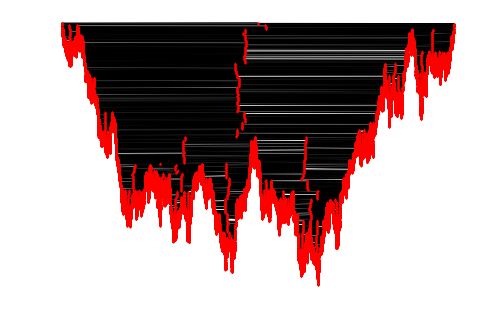

In [16]:
plot_tree(G_gt_20000, filename="output/G_gt_20000.pdf")

In [17]:
G_gt_10000 = random_tree([1, 0, 1], min_size=10000)

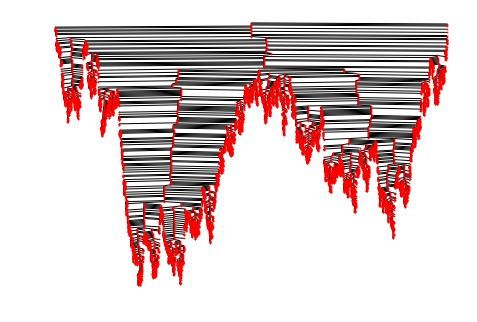

In [18]:
plot_tree(G_gt_10000, filename="output/G_gt_10000.pdf")

In [19]:
G_gt_5000 = random_tree([1, 0, 1], min_size=5000)

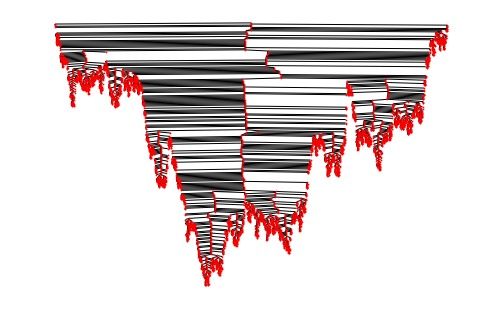

In [20]:
plot_tree(G_gt_5000, filename="output/G_gt_5000.pdf")